In [ ]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive 

In [ ]:
drive.mount('/content/drive')
DIR = "drive/My Drive/Notebooks/Thesis/Readmissions/"

In [ ]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

In [ ]:
!nvidia-smi

Mon Jun 29 17:19:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Natural Language

In [ ]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [ ]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [ ]:
porter = PorterStemmer()

In [ ]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [ ]:
for i, text in enumerate(adm_notes['TEXT']):
   adm_notes.loc[i, 'TEXT'] = (' ').join(tokenize_stem(adm_notes['TEXT'][i]))

# Model
## Words, Train and Test

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Repartition data

In [ ]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2, random_state=42)

Subsample non-readmitted patients to match size of readmitted ones

In [ ]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [ ]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(4900, 10)
(1342, 10)


Sparse Matrix with word count

# Recurrent Neural Network

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, GRU, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

Using TensorFlow backend.


In [ ]:
NUMBER_WORDS = 5000

tokenizer = Tokenizer(num_words=NUMBER_WORDS)
tokenizer.fit_on_texts(df_train['TEXT'])
sequences_train = tokenizer.texts_to_sequences(df_train['TEXT'])
sequences_test = tokenizer.texts_to_sequences(df_test['TEXT'])

X_train = pad_sequences(sequences_train, maxlen=NUMBER_WORDS)
X_test = pad_sequences(sequences_test, maxlen=NUMBER_WORDS)

In [ ]:
y_train = to_categorical(df_train['READM_WITHIN_30'])
y_test = to_categorical(df_test['READM_WITHIN_30'])

In [ ]:
adam = Adam(learning_rate=0.00001)

In [ ]:
model = Sequential()
model.add(Embedding(X_train.shape[1], 128, input_length=X_train.shape[1] ))
model.add(Conv1D(128, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(GRU(128, dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 128)         640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1249, 128)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 820,994
Trainable params: 820,994
Non-trainable params: 0
_________________________________________________________________


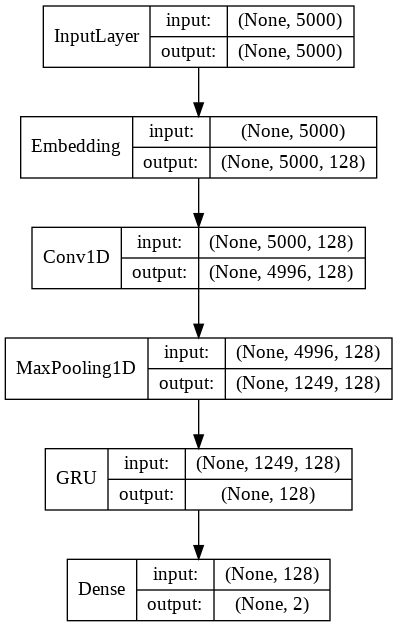

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(X_train, y_train, epochs = 80, batch_size = 64, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3920 samples, validate on 980 samples
Epoch 1/80
3920/3920 [==============================] - 182s 46ms/step - loss: 0.6930 - accuracy: 0.5013 - val_loss: 0.6927 - val_accuracy: 0.5378
Epoch 2/80
3920/3920 [==============================] - 175s 45ms/step - loss: 0.6926 - accuracy: 0.5230 - val_loss: 0.6926 - val_accuracy: 0.5378
Epoch 3/80
3920/3920 [==============================] - 176s 45ms/step - loss: 0.6921 - accuracy: 0.5485 - val_loss: 0.6925 - val_accuracy: 0.5378
Epoch 4/80
3920/3920 [==============================] - 177s 45ms/step - loss: 0.6920 - accuracy: 0.5497 - val_loss: 0.6925 - val_accuracy: 0.5316
Epoch 5/80
3920/3920 [==============================] - 177s 45ms/step - loss: 0.6917 - accuracy: 0.5561 - val_loss: 0.6924 - val_accuracy: 0.5347
Epoch 6/80
3920/3920 [==============================] - 176s 45ms/step - loss: 0.6913 - accuracy: 0.5538 - val_loss: 0.6923 - val_accuracy: 0.5337
Epoch 7/80
3920/3920 [==============================] - 174s 44ms/step 

In [ ]:
print(model.metrics_names)
model.evaluate(X_test, y_test, batch_size=64)

['loss', 'accuracy']
1342/1342 [==============================] - 4s 3ms/step


[0.655388966491432, 0.6162444353103638]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_test_raw = df_test['READM_WITHIN_30']

print(classification_report(y_test_raw, y_pred, digits=3))
print(roc_auc_score(y_test_raw, y_pred))

1342/1342 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

           0      0.629     0.566     0.596       671
           1      0.606     0.666     0.634       671

    accuracy                          0.616      1342
   macro avg      0.617     0.616     0.615      1342
weighted avg      0.617     0.616     0.615      1342

0.6162444113263785


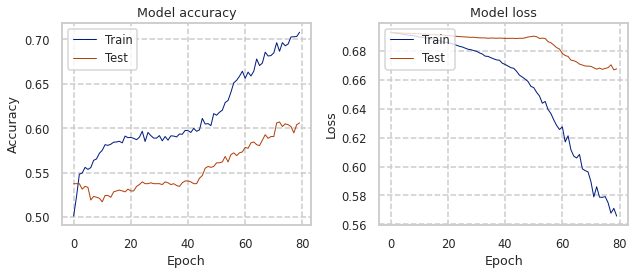

In [ ]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()